In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from matplotlib.ticker import LogLocator

os.environ['PATH'] = os.environ['PATH'] + ':' + os.path.expanduser('~/texlive2025/bin/x86_64-linux/')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

sns.set_style("whitegrid")
sns.set_palette("husl")

In [4]:
datasets = ['adult', 'folktables', 'hmda']
dataset_names = {'adult': 'Adult', 'folktables': 'Folktables', 'hmda': 'HMDA'}

model_classes = ['logistic', 'RF', 'nn']
model_class_names = {'logistic': 'Logistic Regression', 'RF': 'Random Forest', 'nn': 'Neural Network'}


In [ ]:
def plot_cei_comparison(ax, dataset, model_class, with_mrl_assm, max_num_datasets):

    est_means = np.zeros(T)
    true_cei_means = np.zeros(T)
    est_sds = np.zeros(T)
    true_cei_sds = np.zeros(T)
    hi_est = np.zeros(T)
    lo_est = np.zeros(T)
    hi_true_cei = np.zeros(T)
    lo_true_cei = np.zeros(T)

    for i in range(max_num_datasets):
        derived_data_fname = f'algo_data/{dataset}_{model_class}_{i}.csv' if not with_mrl_assm else f'algo_data/{dataset}_{model_class}_mrl_{i}.csv'
        derived_data = pd.read_csv(derived_data_fname)

        est_var_prefix = "no_assm_" if not with_mrl_assm else "mrl_assm_"

        est_means += pd.to_numeric(derived_data[est_var_prefix + 'means'])
        true_cei_means += pd.to_numeric(derived_data['true_cei_means'])
        est_sds += pd.to_numeric(derived_data[est_var_prefix + 'sds'])
        true_cei_sds += pd.to_numeric(derived_data['true_cei_sds'])

    est_means /= max_num_datasets
    true_cei_means /= max_num_datasets
    est_sds /= max_num_datasets
    true_cei_sds /= max_num_datasets

    hi_est = pd.to_numeric(est_means + est_sds)
    lo_est = pd.to_numeric(est_means - est_sds)
    hi_true_cei = pd.to_numeric(true_cei_means + true_cei_sds)
    lo_true_cei = pd.to_numeric(true_cei_means - true_cei_sds)

    sns.lineplot(x=range(1, T+1), y=est_means, label=r'Upper bound ($\bar\mu(\hat U_t) \cdot \bar p_t(\delta)$)', linewidth=2.5, ax=ax, legend=False)
    ax.fill_between(range(1, T+1), lo_est, hi_est, alpha=0.2)
    sns.lineplot(x=range(1, T+1), y=true_cei_means, label=r'Full information ($g(\hat U_t)$)', linewidth=2.5, ax=ax, legend=False)
    ax.fill_between(range(1, T+1), lo_true_cei, hi_true_cei, alpha=0.2)
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[], numticks=5))
    ax.set_ylabel('')
    ax.set_xlabel('')
    ylower = 10e-6
    if dataset in ['adult']:
        ax.set_ylim(ylower, 0.6)
    elif dataset in ['folktables']:
        ax.set_ylim(ylower, 0.6)
    else:
        ax.set_ylim(ylower, 0.6)
    ax.set_xlim(1, T)


def plot_cei_comparison_all(with_mrl_assm=False, max_num_datasets=1, fairlearn=False):
    fig, axes = plt.subplots(3, 3, figsize=(12, 6))

    for j, dataset in enumerate(datasets):
        for i, model_class in enumerate(model_classes):
            mc = model_class if not fairlearn else "fl_" + model_class
            plot_cei_comparison(axes[j][i], dataset, mc, with_mrl_assm, max_num_datasets)

    bigfont = 20
    smallerfont = 17
    fig.supxlabel('Iteration', fontsize=bigfont)
    fig.supylabel('Marginal Gain', fontsize=bigfont)

    for i, model_class in enumerate(model_classes):
        mc_name = model_class_names[model_class] if not fairlearn else "Fairlearn " + model_class_names[model_class]
        axes[0][i].set_title(mc_name, fontsize=smallerfont)

    for i, ds in enumerate(datasets):
        axes[i][0].set_ylabel(dataset_names[ds], fontsize=smallerfont)


    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.53, 1.12), ncol=3, fontsize=bigfont, frameon=True, fancybox=True, shadow=True)

    fig.tight_layout()
    fig_fname_postfix = "" if not with_mrl_assm else "_mrl"
    fig_fname_postfix += "" if not fairlearn else "_fairlearn"
    fig.savefig(f'cei_comparison{fig_fname_postfix}.svg', format='svg', dpi=300, bbox_inches='tight')


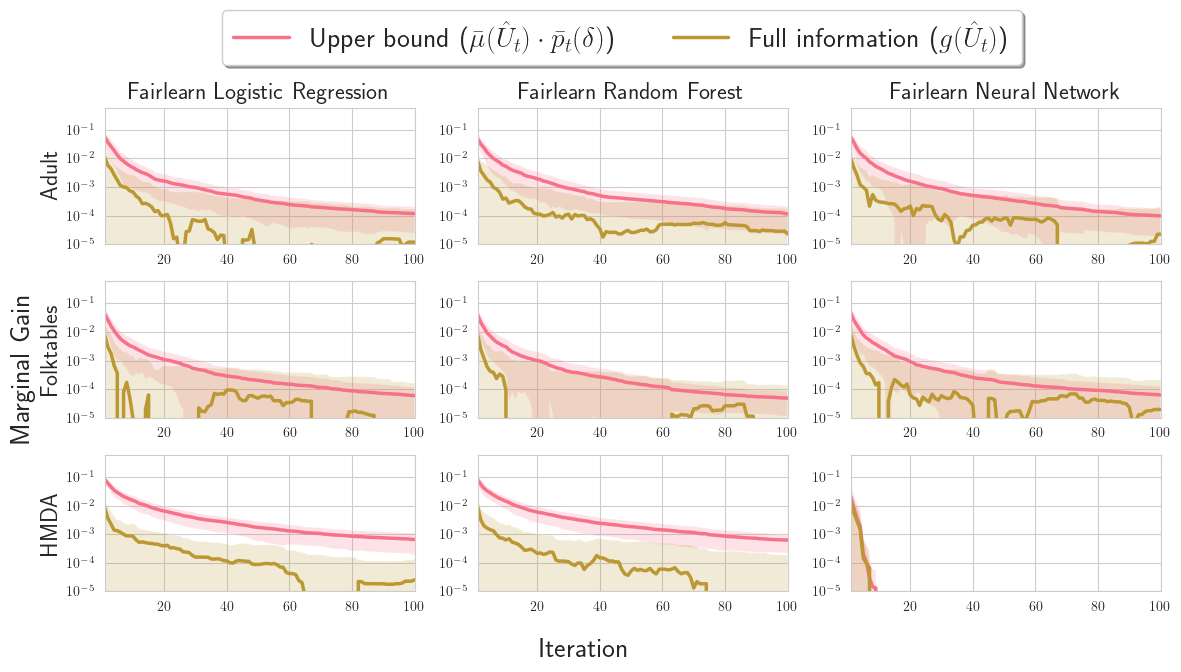

In [ ]:
delta = 0.05

max_num_datasets = 50

T = 100 # number of model training iterations
plot_cei_comparison_all(with_mrl_assm=False, max_num_datasets=max_num_datasets, fairlearn=True)


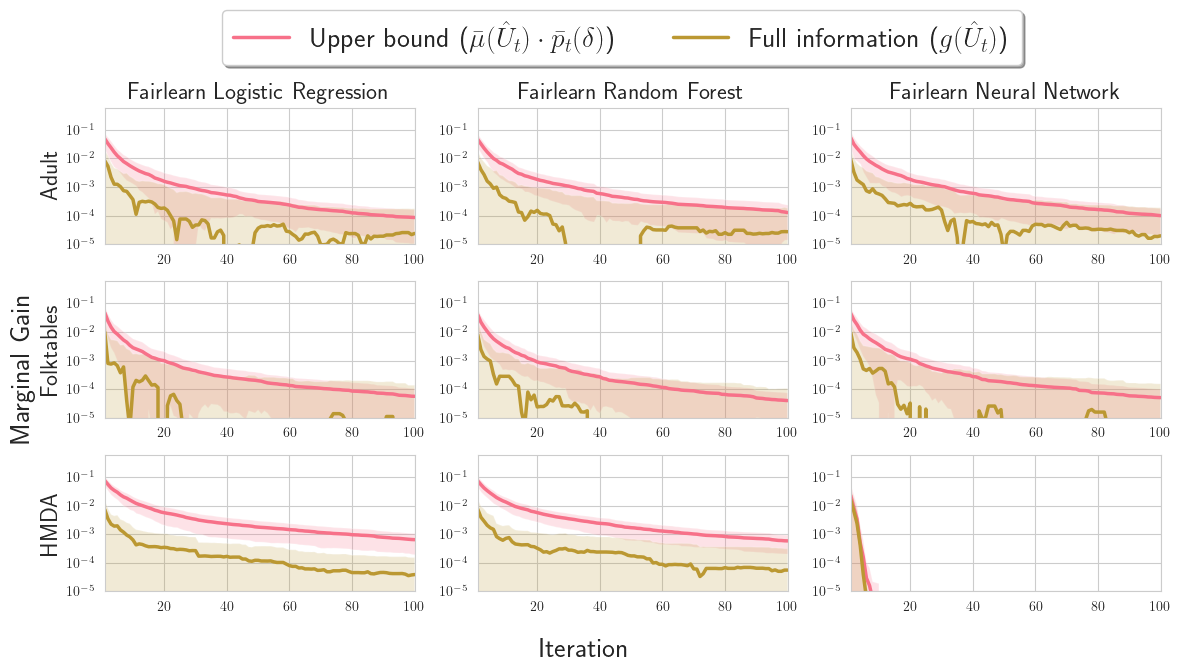

In [11]:
plot_cei_comparison_all(with_mrl_assm=True, max_num_datasets=max_num_datasets, fairlearn=True)

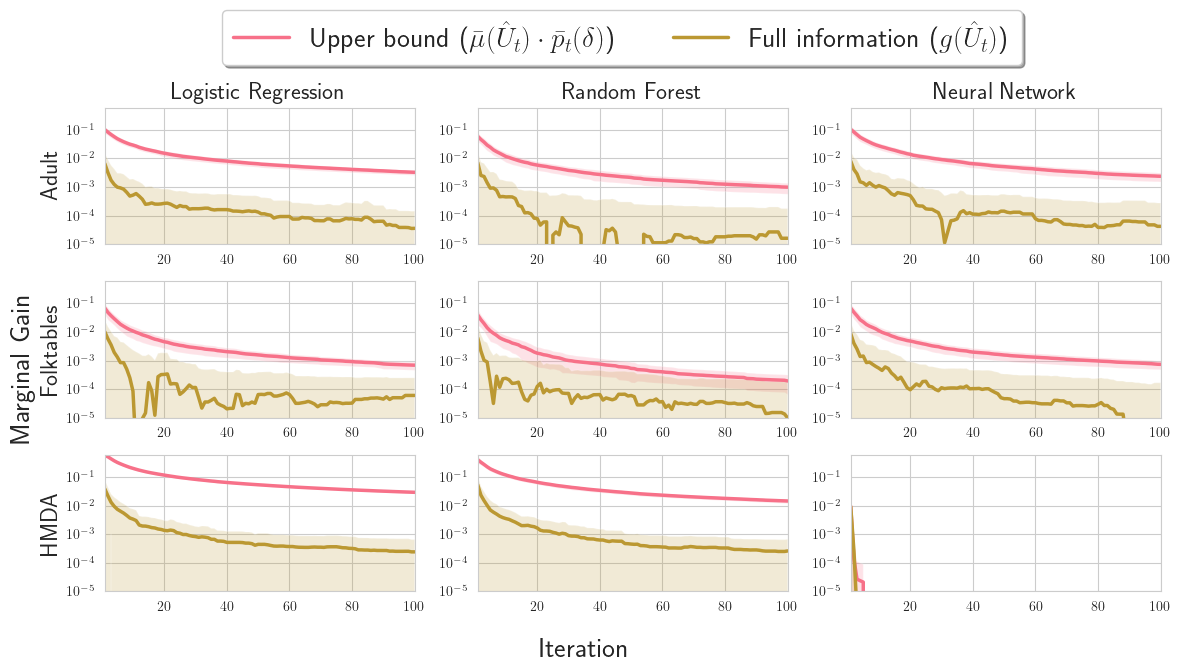

In [8]:
plot_cei_comparison_all(with_mrl_assm=False, max_num_datasets=max_num_datasets, fairlearn=False)


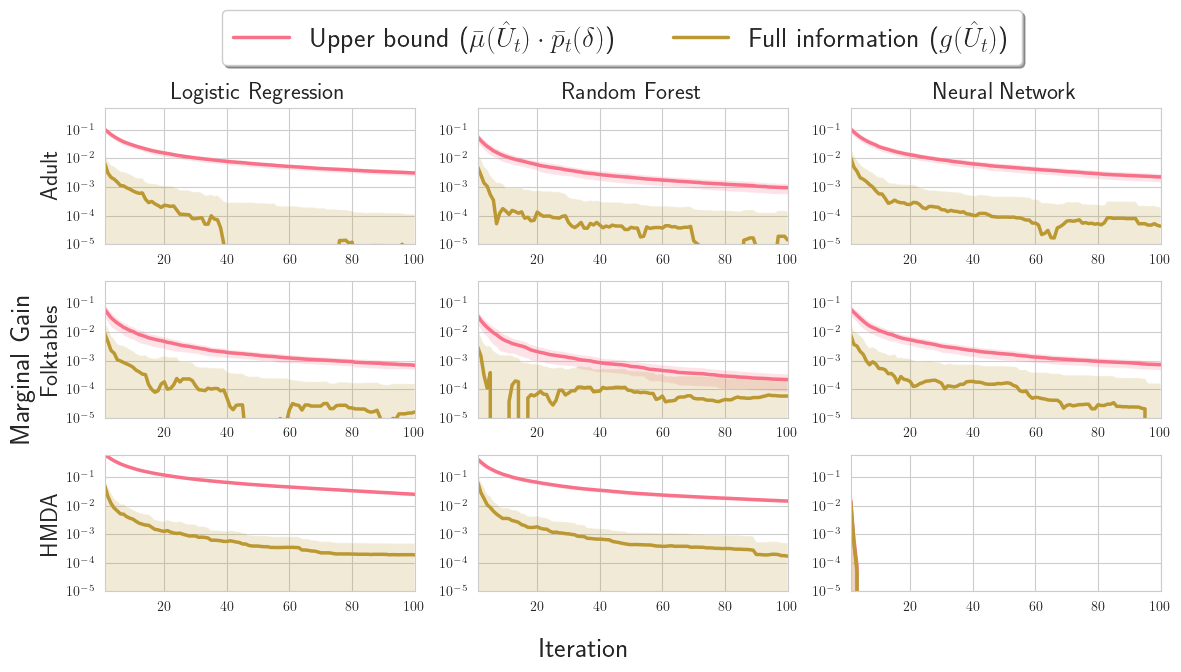

In [9]:
plot_cei_comparison_all(with_mrl_assm=True, max_num_datasets=max_num_datasets, fairlearn=False)


In [80]:
dataset = 'adult'
model_class = 'logistic'

srg_rows = []
accuracy_rows = []
for dataset in datasets:
    results = pd.read_csv(f'results_data/{dataset}_results_{i}.csv')

    srg_means = [np.mean(results[f"{model_class}_df_SRG"]) for model_class in model_classes]
    srg_stds = [np.std(results[f"{model_class}_df_SRG"]) for model_class in model_classes]
    accuracy_means = [np.mean(results[f"{model_class}_df_accuracy"]) for model_class in model_classes]
    accuracy_stds = [np.std(results[f"{model_class}_df_accuracy"]) for model_class in model_classes]
    srg_rows.append(f"{dataset_names[dataset]} & " + " & ".join([f"{srg_means[i]:0.3f} ({srg_stds[i]:0.3f})" for i in range(len(model_classes))]))
    accuracy_rows.append(f"{dataset_names[dataset]} & " + " & ".join([f"{accuracy_means[i]:0.3f} ({accuracy_stds[i]:0.3f})" for i in range(len(model_classes))]))

srg_rows = "\\".join(srg_rows)
accuracy_rows = "\\".join(accuracy_rows)



In [82]:
accuracy_rows

'Adult & 0.824 (0.001) & 0.819 (0.003) & 0.816 (0.003)\\Folktables & 0.777 (0.002) & 0.808 (0.005) & 0.794 (0.004)\\HMDA & 0.594 (0.003) & 0.585 (0.006) & 0.505 (0.062)'